In [66]:
from DBTypes import *
from tqdm import tqdm
from Utilities import Generate_Mean_Std, Normalize
from Constants import *

In [67]:
# hitters = DB_Model_Players.Select_From_DB(cursor, "WHERE (lastProspectYear<? OR lastMLBSeason<?) AND isHitter=?", (10000,10000,1))
# print(len(hitters))

In [68]:
# hitter_means, hitter_devs = Generate_Mean_Std(DB_Model_Players, hitters)
# print(hitter_means.peakWarHitter)
# print(hitter_devs.peakWarHitter)

In [69]:
# all_hitter_stats = []
# for hitter in tqdm(hitters):
#     stats = DB_Model_HitterStats.Select_From_DB(cursor, '''
#         WHERE mlbId=:mlbId AND 
#         (
#             Year<:year OR
#             (Year=:year AND Month<=:month)
#         )
#         ORDER BY Year ASC, MONTH ASC''',
#         {'mlbId':hitter.mlbId,"year":hitter.lastProspectYear,"month":hitter.lastProspectMonth})
#     all_hitter_stats.extend(stats)
    
# hitter_stats_means, hitter_stats_devs = Generate_Mean_Std(DB_Model_HitterStats, all_hitter_stats)
# print(hitter_stats_means.AVGRatio)
# print(hitter_stats_devs.AVGRatio)

In [70]:
import torch

In [71]:
import importlib
import Data_Prep
importlib.reload(Data_Prep)
from Data_Prep import Data_Prep

In [72]:
data_prep = Data_Prep()

In [73]:
hitters, inputs, outputs, max_input_size = data_prep.Generate_IO_Hitters("WHERE (lastProspectYear<? OR lastMLBSeason<?) AND isHitter=?", (10000,10000,1))

In [74]:
# _hitter_input_size = dn.Get_Hitter_Size() + 3
# def Generate_Hitter_Input(hitter : DB_Model_Players, stats : list[DB_Model_HitterStats]) -> torch.Tensor:
#     l = len(stats) + 1
#     input = torch.zeros(l, _hitter_input_size)
#     #print(input.shape)
#     # 1st value is 1 for initialization step, 0 otherwise
#     input[0,0] = 1
#     # 2nd/3rd are draft pick, age at signing
#     input[:,1:3] = dn.Normalize_HitterData(hitter)
#     # Add month stats 1 by 1
#     if len(stats) > 0:
#         tmp = dn.Transform_HitterStats(stats)
#         #print(tmp.shape)
#         input[1:,3:] = tmp
#     return input

In [75]:
# def Generate_Hitter_Output(hitter: DB_Model_Players, length : int) -> torch.Tensor:
#     output = torch.zeros(length, 4, dtype=torch.long)
#     output[:,0] = torch.bucketize(torch.tensor(hitter.warHitter), HITTER_TOTAL_WAR_BUCKETS)
#     output[:,1] = torch.bucketize(torch.tensor(hitter.peakWarHitter), HITTER_PEAK_WAR_BUCKETS)
#     output[:,2] = torch.bucketize(torch.tensor(hitter.highestLevelHitter), HITTER_LEVEL_BUCKETS)
#     output[:,3] = torch.bucketize(torch.tensor(hitter.totalPA), HITTER_PA_BUCKETS)
#     return output

In [76]:
# xs = []
# ys = []
# for hitter in tqdm(hitters):
#     stats = DB_Model_HitterStats.Select_From_DB(cursor, '''
#         WHERE mlbId=:mlbId AND 
#         (
#             Year<:year OR
#             (Year=:year AND Month<=:month)
#         )
#         ORDER BY Year ASC, MONTH ASC''',
#         {'mlbId':hitter.mlbId,"year":hitter.lastProspectYear,"month":hitter.lastProspectMonth})
    
#     input = Generate_Hitter_Input(hitter, stats)
#     output = Generate_Hitter_Output(hitter, input.shape[0])
#     xs.append(input)
#     ys.append(output)

In [77]:
# max_input_size = 0
# for x in xs:
#     s = x.shape[0]
#     if s > max_input_size:
#         max_input_size = s
        
# print(max_input_size)

In [78]:
from sklearn.model_selection import train_test_split # type: ignore
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=4980)

train_lengths = torch.tensor([len(seq) for seq in x_train])
test_lengths = torch.tensor([len(seq) for seq in x_test])

x_train_padded = torch.nn.utils.rnn.pad_sequence(x_train)
x_test_padded = torch.nn.utils.rnn.pad_sequence(x_test)
y_train_padded = torch.nn.utils.rnn.pad_sequence(y_train)
y_test_padded = torch.nn.utils.rnn.pad_sequence(y_test)

In [79]:
import Hitter_Dataset
importlib.reload(Hitter_Dataset)
from Hitter_Dataset import Hitter_Dataset

train_hitters_dataset = Hitter_Dataset(x_train_padded, train_lengths, y_train_padded)
test_hitters_dataset = Hitter_Dataset(x_test_padded, test_lengths, y_test_padded)

Train Model

In [80]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Num. Parameters: 29930
Epoch [1/1000], Train Loss: 1.2903, Test Loss: 0.5190
Epoch [2/1000], Train Loss: 0.4482, Test Loss: 0.4780
Epoch [3/1000], Train Loss: 0.4495, Test Loss: 0.4292
Epoch [4/1000], Train Loss: 0.3962, Test Loss: 0.4186
Epoch [5/1000], Train Loss: 0.3960, Test Loss: 0.4019
Epoch [6/1000], Train Loss: 0.3836, Test Loss: 0.3916
Epoch [7/1000], Train Loss: 0.3806, Test Loss: 0.3865
Epoch [8/1000], Train Loss: 0.3718, Test Loss: 0.3840
Epoch [9/1000], Train Loss: 0.3816, Test Loss: 0.4416
Epoch [10/1000], Train Loss: 0.3949, Test Loss: 0.3780
Epoch [11/1000], Train Loss: 0.3556, Test Loss: 0.3704
Epoch [12/1000], Train Loss: 0.3497, Test Loss: 0.3614
Epoch [13/1000], Train Loss: 0.3422, Test Loss: 0.3582
Epoch [14/1000], Train Loss: 0.3444, Test Loss: 0.3667
Epoch [15/1000], Train Loss: 0.3412, Test Loss: 0.3557
Epoch [16/1000], Train Loss: 0.3340, Test Loss: 0.3578
Epoch [17/1000], Train Loss: 0.3297, Test Loss: 0.3474
Epoch [18/1000], Train Loss: 0.3287, Test Loss: 0.3

0.26514952381451923

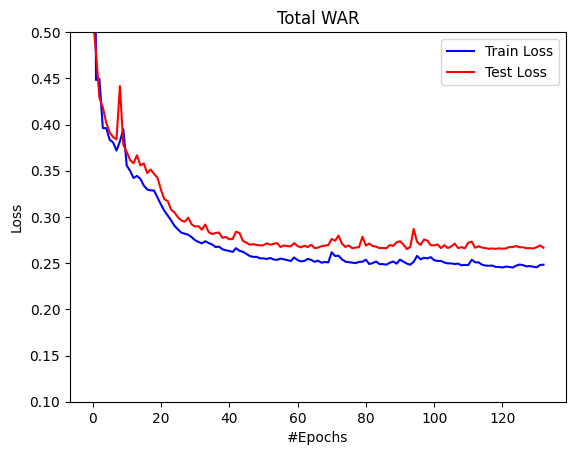

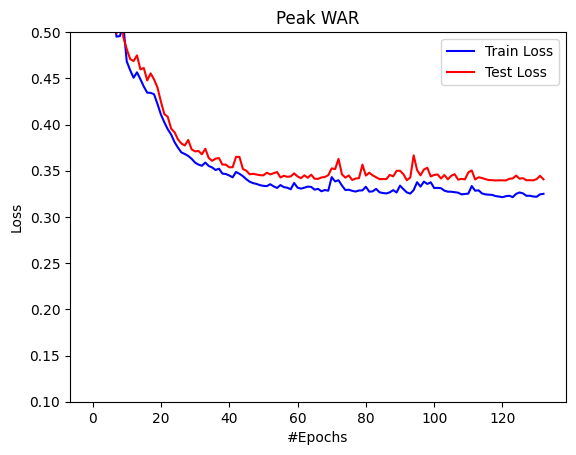

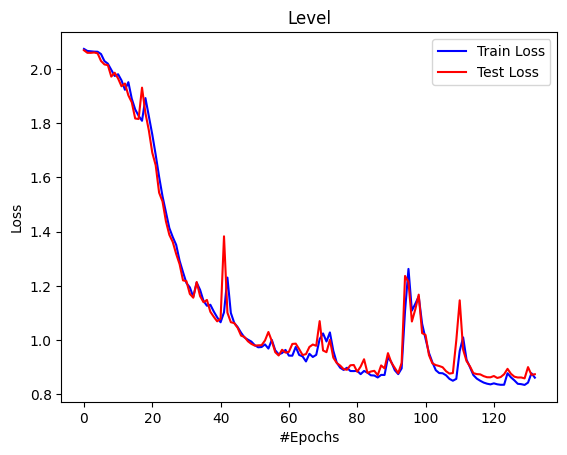

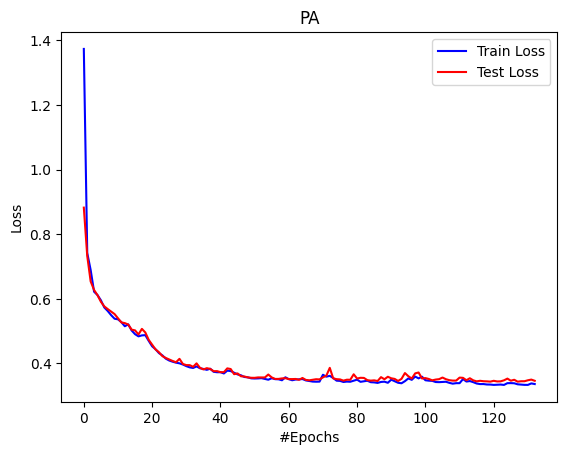

In [81]:
import Hitter_Model
importlib.reload(Hitter_Model)
from Hitter_Model import LSTM_Model, Classification_Loss
from torch.optim import lr_scheduler
import Model_Train
importlib.reload(Model_Train)
from Model_Train import trainAndGraph

batch_size = 1000
hitting_mutators = data_prep.Generate_Hitting_Mutators(batch_size, max_input_size)

num_layers = 5
hidden_size = 50
network = LSTM_Model(x_train_padded[0].shape[1], num_layers, hidden_size, hitting_mutators)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

optimizer = torch.optim.Adam(network.parameters(), lr=0.003)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=20, cooldown=5, verbose=False)
loss_function = Classification_Loss

num_epochs = 1000
training_generator = torch.utils.data.DataLoader(train_hitters_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_hitters_dataset, batch_size=batch_size, shuffle=False)

graph_y_range=(0.1,0.5)
trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, scheduler, num_epochs, logging_interval=1, early_stopping_cutoff=40, should_output=True, graph_y_range=graph_y_range)

Testing

In [82]:
network.load_state_dict(torch.load("no_name.pt"))
network.eval()
network = network.to(device)

In [ ]:
import torch.nn.functional as F

def Check_Hitter(id : int, name : str):
    with torch.no_grad():
        for i, hitter in enumerate(hitters):
            if (hitter.mlbId == id):
                input = inputs[i].unsqueeze(0)
                
                output = outputs[i]
                l = torch.tensor([input.shape[1]])
                twar, pwar, level, pa = network(input.to(device), l.to(device))
                
                torch.set_printoptions(precision=3, sci_mode=False, linewidth=1000)
                print(name)
                print(F.softmax(twar.squeeze(0).squeeze(1), dim=1).cpu())
                #print(F.softmax(level.squeeze(0).squeeze(1), dim=1).cpu())
                print(output[0][0].item())
                #print(output[0][2].item())
                return

Get Hitter Losses

In [ ]:
import torch.nn as nn
losses = []
loss_fn = nn.CrossEntropyLoss(reduction='none')
with torch.no_grad():
    for i, hitter in enumerate(tqdm(hitters)):
        input = inputs[i].unsqueeze(0)
        output = outputs[i]
        l = torch.tensor([input.shape[1]])
        twar, pwar, level, pa = network(input.to(device), l.to(device))
        loss = loss_fn(twar.squeeze(0).cpu(), output[:,0].cpu())
        losses.append(loss.mean().item())
    
import seaborn as sns

print(torch.tensor(losses).mean())
print(torch.tensor(losses).median())

sns.ecdfplot(losses)

 32%|███▏      | 3435/10605 [00:12<00:34, 206.51it/s]

tensor(23.4488)


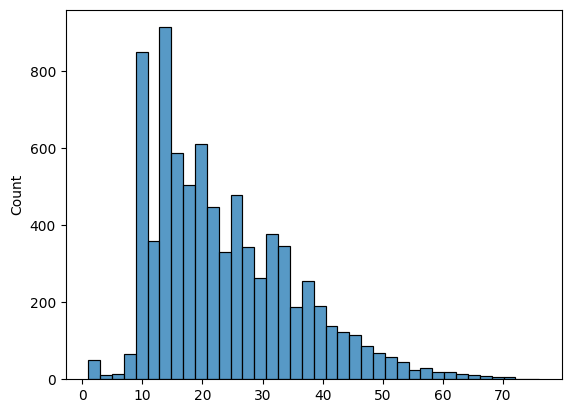

In [ ]:
sns.histplot(train_lengths, binwidth=2)
print(train_lengths.float().mean())

In [ ]:
#Check_Hitter(596146, "Max Kepler")
#Check_Hitter(545361, "Mike Trout")
Check_Hitter(518769, "Michael Harrington")
#Check_Hitter(542454, "Danny Santana")
#Check_Hitter(605381, "Levi Michael")

NameError: name 'xs' is not defined